## Heuristic 4 - Preliminary implementation

### Description
If there are multiple (say 12) deposit transactions coming from a deposit address and later there are 12 withdraw transactions to the same withdraw address, then we can link all these deposit transactions to the withdraw transactions.

In particular, given a withdrawal transaction, an anonimity score is assigned to it:

1) The number of previous withdrawal transactions with the same address as the given withdrawal transaction is registered.

2) The deposit transactions data are grouped by their address. Addresses that deposited the same number of times as the number of withdraws registered, are grouped in a set $C$.

3) An anonimity score (of this heuristic) is assigned to the withdrawal transaction following the formula $P = 1 - 1/|C|$, where P is the anonimity score and $|C|$ is the cardinality of set $C$.

In [25]:
# Set environment variables to better visualize DataFrames.
ENV["COLUMNS"]=10000
ENV["LINES"]=10;

In [2]:
# Import relevant packages.
using DataFrames
using CSV
using StatsPlots
using ProgressBars

In [3]:
# Load withdraw and deposit data.
withdraw_transactions_df = CSV.read("../data/tornado_withdraw_df.csv", DataFrame)
deposit_transactions_df = CSV.read("../data/deposit_transactions.csv", DataFrame);

In [4]:
tornado_addresses = Dict(
    "0xd4b88df4d29f5cedd6857912842cff3b20c8cfa3" => "100 DAI",
    "0xfd8610d20aa15b7b2e3be39b396a1bc3516c7144" => "1000 DAI",
    "0x07687e702b410fa43f4cb4af7fa097918ffd2730" => "10000 DAI",
    "0x23773e65ed146a459791799d01336db287f25334" => "100000 DAI",
    "0x12d66f87a04a9e220743712ce6d9bb1b5616b8fc" => "0.1 ETH",
    "0x47ce0c6ed5b0ce3d3a51fdb1c52dc66a7c3c2936" => "1 ETH",
    "0x910cbd523d972eb0a6f4cae4618ad62622b39dbf" => "10 ETH",
    "0xa160cdab225685da1d56aa342ad8841c3b53f291" => "100 ETH",
    "0xd96f2b1c14db8458374d9aca76e26c3d18364307" => "100 USDC",
    "0x4736dcf1b7a3d580672cce6e7c65cd5cc9cfba9d" => "1000 USDC",
    "0x169ad27a470d064dede56a2d3ff727986b15d52b" => "100 USDT",
    "0x0836222f2b2b24a3f36f98668ed8f0b38d1a872f" => "1000 USDT",
    "0x178169b423a011fff22b9e3f3abea13414ddd0f1" => "0.1 WBTC",
    "0x610b717796ad172b316836ac95a2ffad065ceab4" => "1 WBTC",
    "0xbb93e510bbcd0b7beb5a853875f9ec60275cf498" => "10 WBTC",
    "0x22aaa7720ddd5388a3c0a3333430953c68f1849b" => "5000 cDAI",
    "0x03893a7c7463ae47d46bc7f091665f1893656003" => "50000 cDAI",
    "0x2717c5e28cf931547b621a5dddb772ab6a35b701" => "500000 cDAI",
    "0xd21be7248e0197ee08e0c20d4a96debdac3d20af" => "5000000 cDAI"
    )    

Dict{String, String} with 19 entries:
  "0xd4b88df4d29f5cedd6857912842cff3b20c8cfa3" => "100 DAI"
  "0x07687e702b410fa43f4cb4af7fa097918ffd2730" => "10000 DAI"
  "0x22aaa7720ddd5388a3c0a3333430953c68f1849b" => "5000 cDAI"
  "0xd96f2b1c14db8458374d9aca76e26c3d18364307" => "100 USDC"
  "0xbb93e510bbcd0b7beb5a853875f9ec60275cf498" => "10 WBTC"
  ⋮                                            => ⋮

In [5]:
function compare_transactions(withdraws_dict, deposits_dict)
    for currency in keys(withdraws_dict)
        if !(deposits_dict[currency] >= withdraws_dict[currency])
            return false
        end
    end
    return true
end

compare_transactions (generic function with 1 method)

### Function summary: get_number_of_withdraws
Given a withdraw transaction and the total withdrawals data, the function get_number_of_withdraws returns the number of previous withdrawal transactions with the same address as the withdraw transaction.

In [6]:
function get_number_of_withdraws(withdraw_transaction, withdraw_transactions_df, tornado_addresses)
    
    # The number of withdraws is initialized at 1 since the withdraw_transaction of the first argument is always present
    # in the withdrawal data. Also, the count should be 1 if there is no other transaction with the same address.
    
    n_withdraws = Dict(tornado_addresses[withdraw_transaction.to_address] => 1)
    
    # This for loop counts the number of transactions with the same address. At the end, the total number is returned.
    # The count is done considering that the recipient_address of each of the transactions in the withdraw_transactions_df
    # is the same as the recipient_address of the withdraw_transaction input, and that the timestamp of the rows is earlier
    # than the withdraw_transaction input. 
    # The if clause also filters by the transaction hash, since we don't want to count the same transaction two times.
    
    for row ∈ eachrow(withdraw_transactions_df)
        if (row.recipient_address == withdraw_transaction.recipient_address) && 
            (row.block_timestamp <= withdraw_transaction.block_timestamp) && 
            (row.hash != withdraw_transaction.hash)
            
            if haskey(n_withdraws, tornado_addresses[row.to_address])
                n_withdraws[tornado_addresses[row.to_address]] += 1
            else
                n_withdraws[tornado_addresses[row.to_address]] = 1
            end
        end
    end
    return n_withdraws
end

get_number_of_withdraws (generic function with 1 method)

In [34]:
function get_address_deposits(deposit_transactions_df, tornado_addresses)
    # unique_addresses = unique(deposit_transactions_df[!, "from_address"])
    
    addresses_and_deposits_counts = combine(groupby(deposit_transactions_df, [:from_address, :to_address]), nrow => :count)
    
    addresses_and_deposit_dict = Dict()
    for row in eachrow(addresses_and_deposits_counts)
        if haskey(addresses_and_deposit_dict, row.from_address)
            # if haskey(addresses_and_deposit_dict[row.from_address], tornado_addresses[row.to_address])
            #     addresses_and_deposit_dict[row.from_address][tornado_addresses[row.to_address]] += row.count
            # else
            addresses_and_deposit_dict[row.from_address][tornado_addresses[row.to_address]] = row.count
            # end
        else
            addresses_and_deposit_dict[row.from_address] = Dict(tornado_addresses[row.to_address] => row.count)
        end
    end
    
    return addresses_and_deposit_dict
end

get_address_deposits (generic function with 1 method)

In [35]:
# test
get_address_deposits(deposit_transactions_df, tornado_addresses)

Dict{Any, Any} with 8033 entries:
  "0x50892e106095f415b4b121652a9808fe52664f82" => Dict("1 ETH"=>5, "0.1 ETH"=>1)
  "0x1dbedab746534ee35bb2cdbf970647ba2e22c898" => Dict("1 ETH"=>1)
  "0x04d473d70c0de9174d0013add877734daa7a237a" => Dict("10 ETH"=>1, "1 ETH"=>1)
  "0x96de6ffa0894aad16cc4b7e3c9e52bd8c1c02c91" => Dict("0.1 ETH"=>2)
  "0x390e817d1c8f764dd4228d67dfbe85ee5de2fbcf" => Dict("10 ETH"=>1, "100 ETH"=>1)
  ⋮                                            => ⋮

In [22]:
addresses_and_deposits_counts = combine(groupby(deposit_transactions_df, [:from_address, :to_address]), nrow => :count)

,from_address,to_address,count
,String,String,Int64
1,0xb050dec5a9010f8b77a3962369b7bc737d3ed4a5,0x4736dcf1b7a3d580672cce6e7c65cd5cc9cfba9d,3
2,0x6e92bc493c6abbdd6a1b18416f003de2c873ab50,0x4736dcf1b7a3d580672cce6e7c65cd5cc9cfba9d,2
3,0x50b9d4af009b038506d4d84b035c451d1a3a20bc,0x12d66f87a04a9e220743712ce6d9bb1b5616b8fc,3
4,0x6c6e4816ecfa4481472ff88f32a3e00f2eaa95a1,0x12d66f87a04a9e220743712ce6d9bb1b5616b8fc,7
5,0x8c4c44fd06f7f98f08bf6a9ca156cec9ee1f31f8,0xfd8610d20aa15b7b2e3be39b396a1bc3516c7144,2
6,0x23480df691dbf7c62e967952bbf2067c18cc2f16,0xfd8610d20aa15b7b2e3be39b396a1bc3516c7144,2
7,0x5ba446670288149052645705618f121af76dd19d,0x12d66f87a04a9e220743712ce6d9bb1b5616b8fc,4
8,0xd0698d231d4b65b97a3df9c16aafda8d9b0bda41,0x0836222f2b2b24a3f36f98668ed8f0b38d1a872f,1
9,0x3a456bc9083bfe147719504aee8f296eb7355ee1,0x0836222f2b2b24a3f36f98668ed8f0b38d1a872f,1


### Function summary: get_same_number_of_deposits
Given a number of withdrawal transactions, the function registers all the addresses that have made that same number of deposits. Returns an array with all the addresses that match these requirements.

In [9]:
function get_same_number_of_deposits(n_withdraws, deposit_transactions_df, tornado_addresses)
    
    # The deposits transactions data is first grouped by address, and then combined to get a new 
    # DataFrame with the addresses and their corresponding counts.
    
    address_deposits = get_address_deposits(deposit_transactions_df, tornado_addresses)
    
    return filter(address_deposit -> (Set(keys(n_withdraws))) == Set(keys(last(address_deposit))) &&
    compare_transactions(n_withdraws, last(address_deposit)),
    address_deposits) |> keys |> collect
    
    
    # The addresses are filtered by the number of counts. Only the ones that are equal or larger than the input
    # n_withdraws are returned. Finally, the output of the function is an array with the matching addresses.
    
    # return filter(row -> row.count >= n_withdraws[tornado_addresses[row.to_address]], addresses_and_deposit_counts)[!, :from_address]
end

get_same_number_of_deposits (generic function with 1 method)

In [27]:
xx = get_same_number_of_deposits(c, deposit_transactions_df, tornado_addresses)

54-element Vector{Any}:
 "0x66af9f5c9dc1f4219055f93cb8667c806b45cdcb"
 "0xb631651cb570ba0c0d696bd5e4860cbd214f20a0"
 "0xf4bbc3f8f9dae1b19da82dae46711bda90f06edd"
 ⋮
 "0xebfcef1eda60358d7e0e81db5bef89dfaaa5f3f5"
 "0xbcb7ca4ceed6730cf3d7673fd2218defbcccef6d"

In [28]:
address_deposits = get_address_deposits(deposit_transactions_df, tornado_addresses)

Dict{Any, Any} with 8033 entries:
  "0x50892e106095f415b4b121652a9808fe52664f82" => Dict("1 ETH"=>5, "0.1 ETH"=>1)
  "0x1dbedab746534ee35bb2cdbf970647ba2e22c898" => Dict("1 ETH"=>1)
  "0x04d473d70c0de9174d0013add877734daa7a237a" => Dict("10 ETH"=>1, "1 ETH"=>1)
  "0x96de6ffa0894aad16cc4b7e3c9e52bd8c1c02c91" => Dict("0.1 ETH"=>2)
  "0x390e817d1c8f764dd4228d67dfbe85ee5de2fbcf" => Dict("10 ETH"=>1, "100 ETH"=>1)
  ⋮                                            => ⋮

In [12]:
# test
a = Dict("0.1 ETH" => 4)
address_deposits = get_address_deposits(deposit_transactions_df, tornado_addresses)

filter(t_count_dict -> (Set(keys(c))) == Set(keys(last(t_count_dict))) &&
    compare_transactions(c, last(t_count_dict)),
    address_deposits)
    

LoadError: UndefVarError: c not defined

In [26]:
a = collect(keys(address_deposits))[803]
address_deposits[a]
c = Dict("10 ETH" => 1, "100 ETH" => 1, "1 ETH" => 1, "0.1 ETH" => 1)

Dict{String, Int64} with 4 entries:
  "10 ETH"  => 1
  "100 ETH" => 1
  "1 ETH"   => 1
  "0.1 ETH" => 1

### Function summary: get_same_number_of_deposits_heuristic
Given a withdraw_transaction and the deposit and withdraw data, compute the anonimity score of the transaction, based on this heuristic.

In [14]:
function same_number_of_deposits_heuristic(withdraw_transaction, deposit_transactions_df, withdraw_transactions_df, tornado_addresses)
    
    # We calculate the number of withdrawals of the address from the withdraw_transaction given as input.
    
    n_withdraws = get_number_of_withdraws(withdraw_transaction, withdraw_transactions_df, tornado_addresses)
        
    # Based on n_withdraws, the set of the addresses that have the same number of deposits is calculated.
    
    Ϛ = get_same_number_of_deposits(n_withdraws, deposit_transactions_df, tornado_addresses)
    
    # The anonimity score P is computed.
    
    P = 1 - 1/length(Ϛ)
    
    # Since there is a chance that the cardinality of the set is 0, we handle this case and return the anonimity
    # score.
    
    return isinf(P) ? 1 : P
end

same_number_of_deposits_heuristic (generic function with 1 method)

In [15]:
# Just for testing an example, we select a random withdraw_transaction
withdraw_transaction = withdraw_transactions_df[11,:]

,Column1,hash,nonce,transaction_index,from_address,to_address,value,gas,gas_price,input,receipt_cumulative_gas_used,receipt_gas_used,receipt_contract_address,receipt_root,receipt_status,block_timestamp,block_number,block_hash,max_fee_per_gas,max_priority_fee_per_gas,transaction_type,receipt_effective_gas_price,recipient_address
,Int64,String,Int64,Int64,String,String,Int64,Int64,Int64,String,Int64,Int64,Missing,Missing,Int64,String31,Int64,String,Missing,Missing,Missing,Int64,String
11,10,0x3093a8c80989c31f46f7d30e7843f1518cf1546a04973cdd7f6c8d3f02a46459,6,68,0x00c975b77a640aae18d9ddfc22d87bbeaa9cc451,0x47ce0c6ed5b0ce3d3a51fdb1c52dc66a7c3c2936,0,421736,51000000000,0x21a0adb600000000000000000000000000000000000000000000000000000000000000e01f8995dcf4eae32dc1c26857780cb0e264444ba6a71827bfa56cd7f845e805e825616e2d5741a11ed8b9202ead2e0005a73aa179c6db7051ce1e7cb7e0eddcaf00000000000000000000000000c975b77a640aae18d9ddfc22d87bbeaa9cc45100000000000000000000000000c975b77a640aae18d9ddfc22d87bbeaa9cc45100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000010013bcb32f17c000960572b8aa3a95a141b92931e1d0a1fa085f9ee4371262f70104434840c32bb33e4897001c70166602252046e6ddee4d55d0d058406c75b69d29b9e5266511b0ddd318a8645a0fc076b55391aec1ae22cfeba67650dac95cec05709a2094db4aca01e30e3e10c2a7d707ac0ac04bf5b52ad091f23140f9254a1efd27e2a6c86355a8c783160ffd3dfece1ed92f4454216f228cfc789684f16f12b0eb1bc5cbc69bf29692433a2ec419f801e016c33655f24ef9d2cf35efba640cf20e7fe1801d4b767cae3437c3af9fbaf487cc66c9441ec43bc4bd7403eed514adcea4d4f7187ee1c7b128fdbe125e66a5694b51ea0ca38bc366bb1ad33198,6905756,321736,missing,missing,1,2020-12-17 21:33:11 UTC,11473110,0xba9f8e7c1acb9e67be53a438a67eca7606e67aa6eb59343a625cfe0590801eac,missing,missing,missing,51000000000,0x00C975B77a640aaE18D9dDFc22d87bBeAa9CC451


In [16]:
get_number_of_withdraws(withdraw_transaction, withdraw_transactions_df, tornado_addresses)

Dict{String, Int64} with 3 entries:
  "10 ETH"  => 2
  "1 ETH"   => 5
  "0.1 ETH" => 1

Testing the function get_same_number_of_deposits. We can see there are 3 addresses that have done 34 deposits.


In [17]:
# test
deposits_with_same_number = combine(groupby(deposit_transactions_df, [:from_address, :to_address]), nrow => :count)
unique(deposit_transactions_df[!, "from_address"])

8033-element Vector{String}:
 "0xb050dec5a9010f8b77a3962369b7bc737d3ed4a5"
 "0x6e92bc493c6abbdd6a1b18416f003de2c873ab50"
 "0x50b9d4af009b038506d4d84b035c451d1a3a20bc"
 ⋮
 "0x20be90ebfd8395a34740db71d670d99da93b10a9"
 "0x000adf314983ca2d3ab83edb37a5517cc3af000b"

Testing same_number_of_deposits_heuristic with the withdraw_transaction we selected, computes an anonimity score to it.

In [29]:
same_number_of_deposits_heuristic(withdraw_transaction, deposit_transactions_df, withdraw_transactions_df, tornado_addresses)

0.972972972972973

In [30]:
function apply_same_number_of_deposits_heuristic(deposit_transactions_df, withdraw_transactions_df, tornado_addresses)
    
    # An empty dictionary is initialized. It will be used to store the anonimity score associated with each transaction.
    
    tx_hash_and_anonimity_score = Dict()
    
    # Iterate over every row of the withdraw_transactions DataFrame and apply the function same_number_of_deposits_heuristic
    # For each transaction, the anonimity score is computed and appended to the dictionary.
    
    for withdraw_row ∈ ProgressBar(eachrow(withdraw_transactions_df))
        anonimity_score = same_number_of_deposits_heuristic(withdraw_row, deposit_transactions_df, withdraw_transactions_df, tornado_addresses)
        tx_hash_and_anonimity_score[withdraw_row.hash] = anonimity_score
    end
    
    # The dictionary with the transaction hashes and scores is returned
    
    tx_hash_and_anonimity_score
end

apply_same_number_of_deposits_heuristic (generic function with 1 method)

We apply this last function to our data and we obtain a dictionary indicating the score of each withdrawal.

In [31]:
scores = apply_same_number_of_deposits_heuristic(deposit_transactions_df, withdraw_transactions_df, tornado_addresses)


0.0%┣                                          ┫ 0/22.0k [00:00<-18:-20, -0s/it]
0.0%┣                                        ┫ 1/22.0k [00:00<Inf:Inf, InfGs/it]
0.0%┣                                          ┫ 2/22.0k [00:00<01:19:07, 5it/s]
0.0%┣                                             ┫ 4/22.0k [00:00<38:46, 9it/s]
0.0%┣                                            ┫ 6/22.0k [00:00<31:40, 12it/s]
0.0%┣                                            ┫ 7/22.0k [00:01<31:03, 12it/s]
0.0%┣                                            ┫ 9/22.0k [00:01<26:48, 14it/s]
0.0%┣                                           ┫ 11/22.0k [00:01<24:21, 15it/s]
0.1%┣                                           ┫ 13/22.0k [00:01<23:21, 16it/s]
0.1%┣                                           ┫ 15/22.0k [00:01<22:02, 17it/s]
0.1%┣                                           ┫ 17/22.0k [00:01<21:02, 17it/s]
0.1%┣                                           ┫ 19/22.0k [00:01<20:28, 18it/s]
0.1%┣                       

0.8%┣▍                                         ┫ 184/22.0k [00:08<16:18, 22it/s]
0.8%┣▍                                         ┫ 186/22.0k [00:08<16:18, 22it/s]
0.9%┣▍                                         ┫ 188/22.0k [00:08<16:16, 22it/s]
0.9%┣▍                                         ┫ 189/22.0k [00:08<16:17, 22it/s]
0.9%┣▍                                         ┫ 191/22.0k [00:08<16:14, 22it/s]
0.9%┣▍                                         ┫ 193/22.0k [00:09<16:12, 22it/s]
0.9%┣▍                                         ┫ 195/22.0k [00:09<16:12, 22it/s]
0.9%┣▍                                         ┫ 197/22.0k [00:09<16:09, 23it/s]
0.9%┣▍                                         ┫ 199/22.0k [00:09<16:08, 23it/s]
0.9%┣▍                                         ┫ 200/22.0k [00:09<16:10, 22it/s]
0.9%┣▍                                         ┫ 201/22.0k [00:09<16:16, 22it/s]
0.9%┣▍                                         ┫ 202/22.0k [00:09<16:17, 22it/s]
0.9%┣▍                      

1.7%┣▊                                         ┫ 377/22.0k [00:16<15:13, 24it/s]
1.7%┣▊                                         ┫ 379/22.0k [00:16<15:12, 24it/s]
1.7%┣▊                                         ┫ 381/22.0k [00:16<15:11, 24it/s]
1.7%┣▊                                         ┫ 383/22.0k [00:16<15:12, 24it/s]
1.7%┣▊                                         ┫ 385/22.0k [00:16<15:11, 24it/s]
1.8%┣▊                                         ┫ 387/22.0k [00:16<15:10, 24it/s]
1.8%┣▊                                         ┫ 389/22.0k [00:16<15:10, 24it/s]
1.8%┣▊                                         ┫ 391/22.0k [00:16<15:09, 24it/s]
1.8%┣▊                                         ┫ 393/22.0k [00:16<15:08, 24it/s]
1.8%┣▊                                         ┫ 395/22.0k [00:17<15:08, 24it/s]
1.8%┣▊                                         ┫ 397/22.0k [00:17<15:07, 24it/s]
1.8%┣▊                                         ┫ 399/22.0k [00:17<15:06, 24it/s]
1.8%┣▊                      

2.6%┣█                                         ┫ 576/22.0k [00:23<14:35, 24it/s]
2.6%┣█                                         ┫ 578/22.0k [00:24<14:35, 25it/s]
2.6%┣█                                         ┫ 580/22.0k [00:24<14:34, 25it/s]
2.6%┣█                                         ┫ 582/22.0k [00:24<14:34, 25it/s]
2.7%┣█▏                                        ┫ 584/22.0k [00:24<14:34, 25it/s]
2.7%┣█▏                                        ┫ 586/22.0k [00:24<14:34, 25it/s]
2.7%┣█▏                                        ┫ 587/22.0k [00:24<14:34, 25it/s]
2.7%┣█▏                                        ┫ 589/22.0k [00:24<14:33, 25it/s]
2.7%┣█▏                                        ┫ 591/22.0k [00:24<14:33, 25it/s]
2.7%┣█▏                                        ┫ 593/22.0k [00:24<14:33, 25it/s]
2.7%┣█▏                                        ┫ 595/22.0k [00:24<14:33, 25it/s]
2.7%┣█▏                                        ┫ 597/22.0k [00:24<14:32, 25it/s]
2.7%┣█▏                     

3.5%┣█▌                                        ┫ 772/22.0k [00:31<14:14, 25it/s]
3.5%┣█▌                                        ┫ 774/22.0k [00:31<14:13, 25it/s]
3.5%┣█▌                                        ┫ 776/22.0k [00:31<14:13, 25it/s]
3.5%┣█▌                                        ┫ 778/22.0k [00:31<14:13, 25it/s]
3.5%┣█▌                                        ┫ 780/22.0k [00:31<14:13, 25it/s]
3.6%┣█▌                                        ┫ 782/22.0k [00:31<14:12, 25it/s]
3.6%┣█▌                                        ┫ 784/22.0k [00:31<14:13, 25it/s]
3.6%┣█▌                                        ┫ 786/22.0k [00:32<14:12, 25it/s]
3.6%┣█▌                                        ┫ 788/22.0k [00:32<14:12, 25it/s]
3.6%┣█▌                                        ┫ 790/22.0k [00:32<14:12, 25it/s]
3.6%┣█▌                                        ┫ 792/22.0k [00:32<14:11, 25it/s]
3.6%┣█▌                                        ┫ 794/22.0k [00:32<14:11, 25it/s]
3.6%┣█▌                     

4.3%┣█▉                                        ┫ 949/22.0k [00:39<14:22, 24it/s]
4.3%┣█▉                                        ┫ 951/22.0k [00:39<14:22, 24it/s]
4.3%┣█▉                                        ┫ 952/22.0k [00:39<14:22, 24it/s]
4.3%┣█▉                                        ┫ 954/22.0k [00:39<14:22, 24it/s]
4.3%┣█▉                                        ┫ 956/22.0k [00:39<14:22, 24it/s]
4.4%┣█▉                                        ┫ 958/22.0k [00:39<14:22, 24it/s]
4.4%┣█▉                                        ┫ 960/22.0k [00:39<14:22, 24it/s]
4.4%┣█▉                                        ┫ 962/22.0k [00:39<14:22, 24it/s]
4.4%┣█▉                                        ┫ 963/22.0k [00:39<14:22, 24it/s]
4.4%┣█▉                                        ┫ 965/22.0k [00:39<14:22, 24it/s]
4.4%┣█▉                                        ┫ 967/22.0k [00:40<14:22, 24it/s]
4.4%┣█▉                                        ┫ 969/22.0k [00:40<14:22, 24it/s]
4.4%┣█▉                     

5.2%┣██▏                                      ┫ 1.1k/22.0k [00:47<14:18, 24it/s]
5.2%┣██▏                                      ┫ 1.1k/22.0k [00:47<14:18, 24it/s]
5.2%┣██▏                                      ┫ 1.1k/22.0k [00:47<14:18, 24it/s]
5.2%┣██▏                                      ┫ 1.1k/22.0k [00:47<14:18, 24it/s]
5.2%┣██▏                                      ┫ 1.2k/22.0k [00:47<14:18, 24it/s]
5.2%┣██▏                                      ┫ 1.2k/22.0k [00:47<14:17, 24it/s]
5.2%┣██▏                                      ┫ 1.2k/22.0k [00:47<14:18, 24it/s]
5.3%┣██▏                                      ┫ 1.2k/22.0k [00:47<14:18, 24it/s]
5.3%┣██▏                                      ┫ 1.2k/22.0k [00:48<14:17, 24it/s]
5.3%┣██▏                                      ┫ 1.2k/22.0k [00:48<14:18, 24it/s]
5.3%┣██▏                                      ┫ 1.2k/22.0k [00:48<14:18, 24it/s]
5.3%┣██▏                                      ┫ 1.2k/22.0k [00:48<14:17, 24it/s]
5.3%┣██▏                    

6.1%┣██▌                                      ┫ 1.3k/22.0k [00:55<14:11, 24it/s]
6.1%┣██▌                                      ┫ 1.3k/22.0k [00:55<14:11, 24it/s]
6.1%┣██▌                                      ┫ 1.3k/22.0k [00:55<14:11, 24it/s]
6.1%┣██▌                                      ┫ 1.3k/22.0k [00:55<14:11, 24it/s]
6.1%┣██▌                                      ┫ 1.3k/22.0k [00:55<14:11, 24it/s]
6.1%┣██▌                                      ┫ 1.3k/22.0k [00:55<14:10, 24it/s]
6.1%┣██▌                                      ┫ 1.3k/22.0k [00:55<14:10, 24it/s]
6.1%┣██▌                                      ┫ 1.4k/22.0k [00:56<14:10, 24it/s]
6.1%┣██▌                                      ┫ 1.4k/22.0k [00:56<14:10, 24it/s]
6.2%┣██▌                                      ┫ 1.4k/22.0k [00:56<14:10, 24it/s]
6.2%┣██▌                                      ┫ 1.4k/22.0k [00:56<14:10, 24it/s]
6.2%┣██▌                                      ┫ 1.4k/22.0k [00:56<14:10, 24it/s]
6.2%┣██▌                    

7.0%┣██▉                                      ┫ 1.5k/22.0k [01:03<14:00, 24it/s]
7.0%┣██▉                                      ┫ 1.5k/22.0k [01:03<14:00, 24it/s]
7.0%┣██▉                                      ┫ 1.5k/22.0k [01:03<14:00, 24it/s]
7.0%┣██▉                                      ┫ 1.5k/22.0k [01:03<13:59, 24it/s]
7.0%┣██▉                                      ┫ 1.5k/22.0k [01:03<13:59, 24it/s]
7.0%┣██▉                                      ┫ 1.5k/22.0k [01:03<13:59, 24it/s]
7.0%┣██▉                                      ┫ 1.5k/22.0k [01:03<13:59, 24it/s]
7.0%┣██▉                                      ┫ 1.5k/22.0k [01:03<13:59, 24it/s]
7.0%┣██▉                                      ┫ 1.5k/22.0k [01:03<13:59, 24it/s]
7.0%┣██▉                                      ┫ 1.5k/22.0k [01:03<13:59, 24it/s]
7.0%┣███                                      ┫ 1.6k/22.0k [01:04<13:59, 24it/s]
7.1%┣███                                      ┫ 1.6k/22.0k [01:04<13:59, 24it/s]
7.1%┣███                    

7.8%┣███▏                                     ┫ 1.7k/22.0k [01:11<13:51, 24it/s]
7.9%┣███▏                                     ┫ 1.7k/22.0k [01:11<13:51, 24it/s]
7.9%┣███▎                                     ┫ 1.7k/22.0k [01:11<13:51, 24it/s]
7.9%┣███▎                                     ┫ 1.7k/22.0k [01:11<13:51, 24it/s]
7.9%┣███▎                                     ┫ 1.7k/22.0k [01:11<13:51, 24it/s]
7.9%┣███▎                                     ┫ 1.7k/22.0k [01:11<13:50, 24it/s]
7.9%┣███▎                                     ┫ 1.7k/22.0k [01:11<13:51, 24it/s]
7.9%┣███▎                                     ┫ 1.7k/22.0k [01:11<13:50, 24it/s]
7.9%┣███▎                                     ┫ 1.7k/22.0k [01:11<13:50, 24it/s]
7.9%┣███▎                                     ┫ 1.7k/22.0k [01:11<13:51, 24it/s]
7.9%┣███▎                                     ┫ 1.7k/22.0k [01:12<13:50, 24it/s]
7.9%┣███▎                                     ┫ 1.7k/22.0k [01:12<13:50, 24it/s]
8.0%┣███▎                   

8.7%┣███▋                                     ┫ 1.9k/22.0k [01:19<13:42, 24it/s]
8.7%┣███▋                                     ┫ 1.9k/22.0k [01:19<13:42, 24it/s]
8.8%┣███▋                                     ┫ 1.9k/22.0k [01:19<13:42, 24it/s]
8.8%┣███▋                                     ┫ 1.9k/22.0k [01:19<13:42, 24it/s]
8.8%┣███▋                                     ┫ 1.9k/22.0k [01:19<13:42, 24it/s]
8.8%┣███▋                                     ┫ 1.9k/22.0k [01:19<13:42, 24it/s]
8.8%┣███▋                                     ┫ 1.9k/22.0k [01:19<13:42, 24it/s]
8.8%┣███▋                                     ┫ 1.9k/22.0k [01:19<13:42, 24it/s]
8.8%┣███▋                                     ┫ 1.9k/22.0k [01:19<13:42, 24it/s]
8.8%┣███▋                                     ┫ 1.9k/22.0k [01:19<13:42, 24it/s]
8.8%┣███▋                                     ┫ 1.9k/22.0k [01:19<13:43, 24it/s]
8.8%┣███▋                                     ┫ 1.9k/22.0k [01:19<13:43, 24it/s]
8.8%┣███▋                   

9.3%┣███▉                                     ┫ 2.1k/22.0k [01:26<13:59, 24it/s]
9.3%┣███▉                                     ┫ 2.1k/22.0k [01:26<13:59, 24it/s]
9.4%┣███▉                                     ┫ 2.1k/22.0k [01:26<13:59, 24it/s]
9.4%┣███▉                                     ┫ 2.1k/22.0k [01:27<13:59, 24it/s]
9.4%┣███▉                                     ┫ 2.1k/22.0k [01:27<13:59, 24it/s]
9.4%┣███▉                                     ┫ 2.1k/22.0k [01:27<13:59, 24it/s]
9.4%┣███▉                                     ┫ 2.1k/22.0k [01:27<13:59, 24it/s]
9.4%┣███▉                                     ┫ 2.1k/22.0k [01:27<13:59, 24it/s]
9.4%┣███▉                                     ┫ 2.1k/22.0k [01:27<13:58, 24it/s]
9.4%┣███▉                                     ┫ 2.1k/22.0k [01:27<13:58, 24it/s]
9.4%┣███▉                                     ┫ 2.1k/22.0k [01:27<13:58, 24it/s]
9.4%┣███▉                                     ┫ 2.1k/22.0k [01:27<13:58, 24it/s]
9.4%┣███▉                   

10.2%┣████                                    ┫ 2.3k/22.0k [01:34<13:49, 24it/s]
10.2%┣████                                    ┫ 2.3k/22.0k [01:34<13:49, 24it/s]
10.2%┣████                                    ┫ 2.3k/22.0k [01:35<13:49, 24it/s]
10.3%┣████                                    ┫ 2.3k/22.0k [01:35<13:48, 24it/s]
10.3%┣████                                    ┫ 2.3k/22.0k [01:35<13:48, 24it/s]
10.3%┣████                                    ┫ 2.3k/22.0k [01:35<13:48, 24it/s]
10.3%┣████▏                                   ┫ 2.3k/22.0k [01:35<13:48, 24it/s]
10.3%┣████▏                                   ┫ 2.3k/22.0k [01:35<13:48, 24it/s]
10.3%┣████▏                                   ┫ 2.3k/22.0k [01:35<13:48, 24it/s]
10.3%┣████▏                                   ┫ 2.3k/22.0k [01:35<13:48, 24it/s]
10.3%┣████▏                                   ┫ 2.3k/22.0k [01:35<13:48, 24it/s]
10.3%┣████▏                                   ┫ 2.3k/22.0k [01:35<13:48, 24it/s]
10.3%┣████▏                 

11.1%┣████▌                                   ┫ 2.4k/22.0k [01:42<13:39, 24it/s]
11.1%┣████▌                                   ┫ 2.5k/22.0k [01:42<13:39, 24it/s]
11.1%┣████▌                                   ┫ 2.5k/22.0k [01:43<13:38, 24it/s]
11.1%┣████▌                                   ┫ 2.5k/22.0k [01:43<13:38, 24it/s]
11.2%┣████▌                                   ┫ 2.5k/22.0k [01:43<13:38, 24it/s]
11.2%┣████▌                                   ┫ 2.5k/22.0k [01:43<13:38, 24it/s]
11.2%┣████▌                                   ┫ 2.5k/22.0k [01:43<13:38, 24it/s]
11.2%┣████▌                                   ┫ 2.5k/22.0k [01:43<13:38, 24it/s]
11.2%┣████▌                                   ┫ 2.5k/22.0k [01:43<13:38, 24it/s]
11.2%┣████▌                                   ┫ 2.5k/22.0k [01:43<13:38, 24it/s]
11.2%┣████▌                                   ┫ 2.5k/22.0k [01:43<13:38, 24it/s]
11.2%┣████▌                                   ┫ 2.5k/22.0k [01:43<13:38, 24it/s]
11.2%┣████▌                 

12.0%┣████▉                                   ┫ 2.6k/22.0k [01:50<13:29, 24it/s]
12.0%┣████▉                                   ┫ 2.6k/22.0k [01:51<13:29, 24it/s]
12.0%┣████▉                                   ┫ 2.6k/22.0k [01:51<13:28, 24it/s]
12.0%┣████▉                                   ┫ 2.7k/22.0k [01:51<13:28, 24it/s]
12.1%┣████▉                                   ┫ 2.7k/22.0k [01:51<13:28, 24it/s]
12.1%┣████▉                                   ┫ 2.7k/22.0k [01:51<13:28, 24it/s]
12.1%┣████▉                                   ┫ 2.7k/22.0k [01:51<13:28, 24it/s]
12.1%┣████▉                                   ┫ 2.7k/22.0k [01:51<13:28, 24it/s]
12.1%┣████▉                                   ┫ 2.7k/22.0k [01:51<13:28, 24it/s]
12.1%┣████▉                                   ┫ 2.7k/22.0k [01:51<13:28, 24it/s]
12.1%┣████▉                                   ┫ 2.7k/22.0k [01:51<13:28, 24it/s]
12.1%┣████▉                                   ┫ 2.7k/22.0k [01:51<13:28, 24it/s]
12.1%┣████▉                 

12.9%┣█████▏                                  ┫ 2.8k/22.0k [01:58<13:19, 24it/s]
12.9%┣█████▏                                  ┫ 2.8k/22.0k [01:58<13:19, 24it/s]
12.9%┣█████▏                                  ┫ 2.8k/22.0k [01:59<13:19, 24it/s]
12.9%┣█████▏                                  ┫ 2.8k/22.0k [01:59<13:18, 24it/s]
12.9%┣█████▏                                  ┫ 2.9k/22.0k [01:59<13:18, 24it/s]
13.0%┣█████▏                                  ┫ 2.9k/22.0k [01:59<13:18, 24it/s]
13.0%┣█████▏                                  ┫ 2.9k/22.0k [01:59<13:18, 24it/s]
13.0%┣█████▏                                  ┫ 2.9k/22.0k [01:59<13:18, 24it/s]
13.0%┣█████▏                                  ┫ 2.9k/22.0k [01:59<13:18, 24it/s]
13.0%┣█████▏                                  ┫ 2.9k/22.0k [01:59<13:18, 24it/s]
13.0%┣█████▏                                  ┫ 2.9k/22.0k [01:59<13:18, 24it/s]
13.0%┣█████▏                                  ┫ 2.9k/22.0k [01:59<13:18, 24it/s]
13.0%┣█████▏                

13.8%┣█████▌                                  ┫ 3.0k/22.0k [02:07<13:10, 24it/s]
13.8%┣█████▌                                  ┫ 3.0k/22.0k [02:07<13:10, 24it/s]
13.8%┣█████▌                                  ┫ 3.0k/22.0k [02:07<13:10, 24it/s]
13.8%┣█████▌                                  ┫ 3.0k/22.0k [02:07<13:09, 24it/s]
13.8%┣█████▌                                  ┫ 3.0k/22.0k [02:07<13:09, 24it/s]
13.9%┣█████▌                                  ┫ 3.0k/22.0k [02:07<13:09, 24it/s]
13.9%┣█████▌                                  ┫ 3.1k/22.0k [02:07<13:09, 24it/s]
13.9%┣█████▌                                  ┫ 3.1k/22.0k [02:07<13:09, 24it/s]
13.9%┣█████▌                                  ┫ 3.1k/22.0k [02:07<13:09, 24it/s]
13.9%┣█████▋                                  ┫ 3.1k/22.0k [02:07<13:09, 24it/s]
13.9%┣█████▋                                  ┫ 3.1k/22.0k [02:07<13:09, 24it/s]
13.9%┣█████▋                                  ┫ 3.1k/22.0k [02:07<13:09, 24it/s]
13.9%┣█████▋                

14.7%┣█████▉                                  ┫ 3.2k/22.0k [02:15<13:02, 24it/s]
14.7%┣█████▉                                  ┫ 3.2k/22.0k [02:15<13:02, 24it/s]
14.7%┣█████▉                                  ┫ 3.2k/22.0k [02:15<13:02, 24it/s]
14.7%┣██████                                  ┫ 3.2k/22.0k [02:15<13:02, 24it/s]
14.7%┣██████                                  ┫ 3.2k/22.0k [02:15<13:02, 24it/s]
14.7%┣██████                                  ┫ 3.2k/22.0k [02:15<13:01, 24it/s]
14.8%┣██████                                  ┫ 3.2k/22.0k [02:15<13:01, 24it/s]
14.8%┣██████                                  ┫ 3.2k/22.0k [02:15<13:01, 24it/s]
14.8%┣██████                                  ┫ 3.3k/22.0k [02:15<13:01, 24it/s]
14.8%┣██████                                  ┫ 3.3k/22.0k [02:15<13:01, 24it/s]
14.8%┣██████                                  ┫ 3.3k/22.0k [02:16<13:01, 24it/s]
14.8%┣██████                                  ┫ 3.3k/22.0k [02:16<13:01, 24it/s]
14.8%┣██████                

15.5%┣██████▏                                 ┫ 3.4k/22.0k [02:23<13:02, 24it/s]
15.5%┣██████▏                                 ┫ 3.4k/22.0k [02:24<13:02, 24it/s]
15.5%┣██████▏                                 ┫ 3.4k/22.0k [02:24<13:02, 24it/s]
15.5%┣██████▏                                 ┫ 3.4k/22.0k [02:24<13:02, 24it/s]
15.5%┣██████▏                                 ┫ 3.4k/22.0k [02:24<13:02, 24it/s]
15.5%┣██████▏                                 ┫ 3.4k/22.0k [02:24<13:02, 24it/s]
15.6%┣██████▎                                 ┫ 3.4k/22.0k [02:24<13:02, 24it/s]
15.6%┣██████▎                                 ┫ 3.4k/22.0k [02:24<13:01, 24it/s]
15.6%┣██████▎                                 ┫ 3.4k/22.0k [02:24<13:01, 24it/s]
15.6%┣██████▎                                 ┫ 3.4k/22.0k [02:24<13:02, 24it/s]
15.6%┣██████▎                                 ┫ 3.4k/22.0k [02:24<13:02, 24it/s]
15.6%┣██████▎                                 ┫ 3.4k/22.0k [02:24<13:02, 24it/s]
15.6%┣██████▎               

16.2%┣██████▌                                 ┫ 3.6k/22.0k [02:31<13:02, 24it/s]
16.2%┣██████▌                                 ┫ 3.6k/22.0k [02:31<13:02, 24it/s]
16.2%┣██████▌                                 ┫ 3.6k/22.0k [02:31<13:03, 24it/s]
16.2%┣██████▌                                 ┫ 3.6k/22.0k [02:31<13:03, 24it/s]
16.2%┣██████▌                                 ┫ 3.6k/22.0k [02:31<13:03, 24it/s]
16.2%┣██████▌                                 ┫ 3.6k/22.0k [02:32<13:03, 24it/s]
16.2%┣██████▌                                 ┫ 3.6k/22.0k [02:32<13:03, 24it/s]
16.2%┣██████▌                                 ┫ 3.6k/22.0k [02:32<13:03, 24it/s]
16.2%┣██████▌                                 ┫ 3.6k/22.0k [02:32<13:03, 24it/s]
16.2%┣██████▌                                 ┫ 3.6k/22.0k [02:32<13:03, 24it/s]
16.2%┣██████▌                                 ┫ 3.6k/22.0k [02:32<13:03, 24it/s]
16.3%┣██████▌                                 ┫ 3.6k/22.0k [02:32<13:03, 24it/s]
16.3%┣██████▌               

17.0%┣██████▉                                 ┫ 3.8k/22.0k [02:39<12:55, 24it/s]
17.1%┣██████▉                                 ┫ 3.8k/22.0k [02:39<12:55, 24it/s]
17.1%┣██████▉                                 ┫ 3.8k/22.0k [02:39<12:55, 24it/s]
17.1%┣██████▉                                 ┫ 3.8k/22.0k [02:39<12:55, 24it/s]
17.1%┣██████▉                                 ┫ 3.8k/22.0k [02:39<12:55, 24it/s]
17.1%┣██████▉                                 ┫ 3.8k/22.0k [02:40<12:55, 24it/s]
17.1%┣██████▉                                 ┫ 3.8k/22.0k [02:40<12:55, 24it/s]
17.1%┣██████▉                                 ┫ 3.8k/22.0k [02:40<12:55, 24it/s]
17.1%┣██████▉                                 ┫ 3.8k/22.0k [02:40<12:54, 24it/s]
17.1%┣██████▉                                 ┫ 3.8k/22.0k [02:40<12:54, 24it/s]
17.1%┣██████▉                                 ┫ 3.8k/22.0k [02:40<12:54, 24it/s]
17.1%┣██████▉                                 ┫ 3.8k/22.0k [02:40<12:54, 24it/s]
17.1%┣██████▉               

17.8%┣███████                                 ┫ 3.9k/22.0k [02:47<12:52, 23it/s]
17.8%┣███████                                 ┫ 3.9k/22.0k [02:47<12:52, 23it/s]
17.8%┣███████▏                                ┫ 3.9k/22.0k [02:47<12:51, 23it/s]
17.8%┣███████▏                                ┫ 3.9k/22.0k [02:47<12:51, 23it/s]
17.8%┣███████▏                                ┫ 3.9k/22.0k [02:47<12:51, 23it/s]
17.8%┣███████▏                                ┫ 3.9k/22.0k [02:47<12:51, 23it/s]
17.8%┣███████▏                                ┫ 3.9k/22.0k [02:47<12:51, 23it/s]
17.8%┣███████▏                                ┫ 3.9k/22.0k [02:47<12:51, 23it/s]
17.8%┣███████▏                                ┫ 3.9k/22.0k [02:47<12:51, 23it/s]
17.8%┣███████▏                                ┫ 3.9k/22.0k [02:47<12:51, 23it/s]
17.9%┣███████▏                                ┫ 3.9k/22.0k [02:47<12:51, 23it/s]
17.9%┣███████▏                                ┫ 3.9k/22.0k [02:47<12:50, 23it/s]
17.9%┣███████▏              

18.6%┣███████▍                                ┫ 4.1k/22.0k [02:54<12:43, 23it/s]
18.6%┣███████▌                                ┫ 4.1k/22.0k [02:55<12:43, 23it/s]
18.6%┣███████▌                                ┫ 4.1k/22.0k [02:55<12:43, 23it/s]
18.6%┣███████▌                                ┫ 4.1k/22.0k [02:55<12:43, 23it/s]
18.6%┣███████▌                                ┫ 4.1k/22.0k [02:55<12:43, 23it/s]
18.6%┣███████▌                                ┫ 4.1k/22.0k [02:55<12:43, 23it/s]
18.6%┣███████▌                                ┫ 4.1k/22.0k [02:55<12:43, 23it/s]
18.6%┣███████▌                                ┫ 4.1k/22.0k [02:55<12:44, 23it/s]
18.7%┣███████▌                                ┫ 4.1k/22.0k [02:55<12:44, 23it/s]
18.7%┣███████▌                                ┫ 4.1k/22.0k [02:55<12:44, 23it/s]
18.7%┣███████▌                                ┫ 4.1k/22.0k [02:55<12:44, 23it/s]
18.7%┣███████▌                                ┫ 4.1k/22.0k [02:55<12:44, 23it/s]
18.7%┣███████▌              

19.4%┣███████▊                                ┫ 4.3k/22.0k [03:02<12:38, 23it/s]
19.4%┣███████▊                                ┫ 4.3k/22.0k [03:02<12:38, 23it/s]
19.4%┣███████▊                                ┫ 4.3k/22.0k [03:02<12:37, 23it/s]
19.4%┣███████▊                                ┫ 4.3k/22.0k [03:03<12:37, 23it/s]
19.4%┣███████▊                                ┫ 4.3k/22.0k [03:03<12:37, 23it/s]
19.4%┣███████▉                                ┫ 4.3k/22.0k [03:03<12:37, 23it/s]
19.5%┣███████▉                                ┫ 4.3k/22.0k [03:03<12:37, 23it/s]
19.5%┣███████▉                                ┫ 4.3k/22.0k [03:03<12:37, 23it/s]
19.5%┣███████▉                                ┫ 4.3k/22.0k [03:03<12:37, 23it/s]
19.5%┣███████▉                                ┫ 4.3k/22.0k [03:03<12:37, 23it/s]
19.5%┣███████▉                                ┫ 4.3k/22.0k [03:03<12:37, 23it/s]
19.5%┣███████▉                                ┫ 4.3k/22.0k [03:03<12:36, 23it/s]
19.5%┣███████▉              

20.2%┣████████                                ┫ 4.4k/22.0k [03:10<12:31, 23it/s]
20.2%┣████████                                ┫ 4.4k/22.0k [03:10<12:31, 23it/s]
20.2%┣████████                                ┫ 4.5k/22.0k [03:10<12:31, 23it/s]
20.2%┣████████                                ┫ 4.5k/22.0k [03:10<12:31, 23it/s]
20.2%┣████████                                ┫ 4.5k/22.0k [03:10<12:30, 23it/s]
20.2%┣████████                                ┫ 4.5k/22.0k [03:10<12:30, 23it/s]
20.3%┣████████                                ┫ 4.5k/22.0k [03:11<12:30, 23it/s]
20.3%┣████████                                ┫ 4.5k/22.0k [03:11<12:30, 23it/s]
20.3%┣████████                                ┫ 4.5k/22.0k [03:11<12:30, 23it/s]
20.3%┣████████▏                               ┫ 4.5k/22.0k [03:11<12:30, 23it/s]
20.3%┣████████▏                               ┫ 4.5k/22.0k [03:11<12:30, 23it/s]
20.3%┣████████▏                               ┫ 4.5k/22.0k [03:11<12:30, 23it/s]
20.3%┣████████▏             

21.1%┣████████▍                               ┫ 4.6k/22.0k [03:18<12:21, 23it/s]
21.1%┣████████▍                               ┫ 4.6k/22.0k [03:18<12:21, 23it/s]
21.1%┣████████▌                               ┫ 4.6k/22.0k [03:18<12:20, 23it/s]
21.1%┣████████▌                               ┫ 4.6k/22.0k [03:18<12:20, 23it/s]
21.1%┣████████▌                               ┫ 4.7k/22.0k [03:18<12:20, 23it/s]
21.1%┣████████▌                               ┫ 4.7k/22.0k [03:18<12:20, 23it/s]
21.2%┣████████▌                               ┫ 4.7k/22.0k [03:18<12:20, 23it/s]
21.2%┣████████▌                               ┫ 4.7k/22.0k [03:19<12:20, 23it/s]
21.2%┣████████▌                               ┫ 4.7k/22.0k [03:19<12:20, 23it/s]
21.2%┣████████▌                               ┫ 4.7k/22.0k [03:19<12:20, 23it/s]
21.2%┣████████▌                               ┫ 4.7k/22.0k [03:19<12:20, 23it/s]
21.2%┣████████▌                               ┫ 4.7k/22.0k [03:19<12:19, 23it/s]
21.2%┣████████▌             

22.0%┣████████▉                               ┫ 4.8k/22.0k [03:26<12:10, 24it/s]
22.0%┣████████▉                               ┫ 4.8k/22.0k [03:26<12:10, 24it/s]
22.0%┣████████▉                               ┫ 4.8k/22.0k [03:26<12:10, 24it/s]
22.0%┣████████▉                               ┫ 4.8k/22.0k [03:26<12:10, 24it/s]
22.0%┣████████▉                               ┫ 4.8k/22.0k [03:26<12:10, 24it/s]
22.0%┣████████▉                               ┫ 4.8k/22.0k [03:26<12:10, 24it/s]
22.0%┣████████▉                               ┫ 4.9k/22.0k [03:26<12:10, 24it/s]
22.1%┣████████▉                               ┫ 4.9k/22.0k [03:26<12:10, 24it/s]
22.1%┣████████▉                               ┫ 4.9k/22.0k [03:26<12:09, 24it/s]
22.1%┣████████▉                               ┫ 4.9k/22.0k [03:27<12:09, 24it/s]
22.1%┣████████▉                               ┫ 4.9k/22.0k [03:27<12:09, 24it/s]
22.1%┣████████▉                               ┫ 4.9k/22.0k [03:27<12:09, 24it/s]
22.1%┣████████▉             

22.9%┣█████████▏                              ┫ 5.0k/22.0k [03:34<12:00, 24it/s]
22.9%┣█████████▏                              ┫ 5.0k/22.0k [03:34<12:00, 24it/s]
22.9%┣█████████▏                              ┫ 5.0k/22.0k [03:34<12:00, 24it/s]
22.9%┣█████████▏                              ┫ 5.0k/22.0k [03:34<12:00, 24it/s]
22.9%┣█████████▏                              ┫ 5.0k/22.0k [03:34<12:00, 24it/s]
22.9%┣█████████▏                              ┫ 5.0k/22.0k [03:34<12:00, 24it/s]
22.9%┣█████████▏                              ┫ 5.0k/22.0k [03:34<11:59, 24it/s]
23.0%┣█████████▏                              ┫ 5.1k/22.0k [03:34<11:59, 24it/s]
23.0%┣█████████▏                              ┫ 5.1k/22.0k [03:34<11:59, 24it/s]
23.0%┣█████████▏                              ┫ 5.1k/22.0k [03:34<11:59, 24it/s]
23.0%┣█████████▏                              ┫ 5.1k/22.0k [03:35<11:59, 24it/s]
23.0%┣█████████▏                              ┫ 5.1k/22.0k [03:35<11:59, 24it/s]
23.0%┣█████████▏            

23.8%┣█████████▌                              ┫ 5.2k/22.0k [03:42<11:50, 24it/s]
23.8%┣█████████▌                              ┫ 5.2k/22.0k [03:42<11:50, 24it/s]
23.8%┣█████████▌                              ┫ 5.2k/22.0k [03:42<11:50, 24it/s]
23.8%┣█████████▌                              ┫ 5.2k/22.0k [03:42<11:50, 24it/s]
23.8%┣█████████▌                              ┫ 5.2k/22.0k [03:42<11:50, 24it/s]
23.8%┣█████████▌                              ┫ 5.2k/22.0k [03:42<11:49, 24it/s]
23.8%┣█████████▌                              ┫ 5.2k/22.0k [03:42<11:49, 24it/s]
23.9%┣█████████▌                              ┫ 5.2k/22.0k [03:42<11:49, 24it/s]
23.9%┣█████████▌                              ┫ 5.3k/22.0k [03:42<11:49, 24it/s]
23.9%┣█████████▌                              ┫ 5.3k/22.0k [03:42<11:49, 24it/s]
23.9%┣█████████▌                              ┫ 5.3k/22.0k [03:42<11:49, 24it/s]
23.9%┣█████████▋                              ┫ 5.3k/22.0k [03:42<11:49, 24it/s]
23.9%┣█████████▋            

24.7%┣█████████▉                              ┫ 5.4k/22.0k [03:50<11:40, 24it/s]
24.7%┣█████████▉                              ┫ 5.4k/22.0k [03:50<11:40, 24it/s]
24.7%┣█████████▉                              ┫ 5.4k/22.0k [03:50<11:40, 24it/s]
24.7%┣█████████▉                              ┫ 5.4k/22.0k [03:50<11:40, 24it/s]
24.7%┣██████████                              ┫ 5.4k/22.0k [03:50<11:40, 24it/s]
24.7%┣██████████                              ┫ 5.4k/22.0k [03:50<11:40, 24it/s]
24.7%┣██████████                              ┫ 5.4k/22.0k [03:50<11:40, 24it/s]
24.8%┣██████████                              ┫ 5.4k/22.0k [03:50<11:39, 24it/s]
24.8%┣██████████                              ┫ 5.5k/22.0k [03:50<11:39, 24it/s]
24.8%┣██████████                              ┫ 5.5k/22.0k [03:50<11:39, 24it/s]
24.8%┣██████████                              ┫ 5.5k/22.0k [03:50<11:39, 24it/s]
24.8%┣██████████                              ┫ 5.5k/22.0k [03:50<11:39, 24it/s]
24.8%┣██████████            

25.6%┣██████████▎                             ┫ 5.6k/22.0k [03:57<11:30, 24it/s]
25.6%┣██████████▎                             ┫ 5.6k/22.0k [03:58<11:30, 24it/s]
25.6%┣██████████▎                             ┫ 5.6k/22.0k [03:58<11:30, 24it/s]
25.6%┣██████████▎                             ┫ 5.6k/22.0k [03:58<11:30, 24it/s]
25.6%┣██████████▎                             ┫ 5.6k/22.0k [03:58<11:30, 24it/s]
25.6%┣██████████▎                             ┫ 5.6k/22.0k [03:58<11:30, 24it/s]
25.6%┣██████████▎                             ┫ 5.6k/22.0k [03:58<11:30, 24it/s]
25.7%┣██████████▎                             ┫ 5.6k/22.0k [03:58<11:30, 24it/s]
25.7%┣██████████▎                             ┫ 5.6k/22.0k [03:58<11:30, 24it/s]
25.7%┣██████████▎                             ┫ 5.7k/22.0k [03:58<11:30, 24it/s]
25.7%┣██████████▎                             ┫ 5.7k/22.0k [03:58<11:30, 24it/s]
25.7%┣██████████▎                             ┫ 5.7k/22.0k [03:58<11:29, 24it/s]
25.7%┣██████████▎           

26.5%┣██████████▋                             ┫ 5.8k/22.0k [04:05<11:21, 24it/s]
26.5%┣██████████▋                             ┫ 5.8k/22.0k [04:05<11:21, 24it/s]
26.5%┣██████████▋                             ┫ 5.8k/22.0k [04:06<11:20, 24it/s]
26.5%┣██████████▋                             ┫ 5.8k/22.0k [04:06<11:20, 24it/s]
26.5%┣██████████▋                             ┫ 5.8k/22.0k [04:06<11:20, 24it/s]
26.5%┣██████████▋                             ┫ 5.8k/22.0k [04:06<11:20, 24it/s]
26.6%┣██████████▋                             ┫ 5.8k/22.0k [04:06<11:20, 24it/s]
26.6%┣██████████▋                             ┫ 5.8k/22.0k [04:06<11:20, 24it/s]
26.6%┣██████████▋                             ┫ 5.8k/22.0k [04:06<11:20, 24it/s]
26.6%┣██████████▋                             ┫ 5.9k/22.0k [04:06<11:20, 24it/s]
26.6%┣██████████▋                             ┫ 5.9k/22.0k [04:06<11:20, 24it/s]
26.6%┣██████████▋                             ┫ 5.9k/22.0k [04:06<11:20, 24it/s]
26.6%┣██████████▋           

27.4%┣███████████                             ┫ 6.0k/22.0k [04:13<11:11, 24it/s]
27.4%┣███████████                             ┫ 6.0k/22.0k [04:13<11:11, 24it/s]
27.4%┣███████████                             ┫ 6.0k/22.0k [04:13<11:11, 24it/s]
27.4%┣███████████                             ┫ 6.0k/22.0k [04:14<11:11, 24it/s]
27.4%┣███████████                             ┫ 6.0k/22.0k [04:14<11:11, 24it/s]
27.4%┣███████████                             ┫ 6.0k/22.0k [04:14<11:11, 24it/s]
27.5%┣███████████                             ┫ 6.0k/22.0k [04:14<11:11, 24it/s]
27.5%┣███████████                             ┫ 6.0k/22.0k [04:14<11:10, 24it/s]
27.5%┣███████████                             ┫ 6.0k/22.0k [04:14<11:10, 24it/s]
27.5%┣███████████                             ┫ 6.0k/22.0k [04:14<11:10, 24it/s]
27.5%┣███████████                             ┫ 6.1k/22.0k [04:14<11:10, 24it/s]
27.5%┣███████████                             ┫ 6.1k/22.0k [04:14<11:10, 24it/s]
27.5%┣███████████           

28.3%┣███████████▎                            ┫ 6.2k/22.0k [04:21<11:02, 24it/s]
28.3%┣███████████▎                            ┫ 6.2k/22.0k [04:21<11:02, 24it/s]
28.3%┣███████████▍                            ┫ 6.2k/22.0k [04:21<11:02, 24it/s]
28.3%┣███████████▍                            ┫ 6.2k/22.0k [04:22<11:01, 24it/s]
28.4%┣███████████▍                            ┫ 6.2k/22.0k [04:22<11:01, 24it/s]
28.4%┣███████████▍                            ┫ 6.2k/22.0k [04:22<11:01, 24it/s]
28.4%┣███████████▍                            ┫ 6.2k/22.0k [04:22<11:01, 24it/s]
28.4%┣███████████▍                            ┫ 6.2k/22.0k [04:22<11:01, 24it/s]
28.4%┣███████████▍                            ┫ 6.2k/22.0k [04:22<11:01, 24it/s]
28.4%┣███████████▍                            ┫ 6.2k/22.0k [04:22<11:01, 24it/s]
28.4%┣███████████▍                            ┫ 6.3k/22.0k [04:22<11:01, 24it/s]
28.4%┣███████████▍                            ┫ 6.3k/22.0k [04:22<11:01, 24it/s]
28.4%┣███████████▍          

29.2%┣███████████▊                            ┫ 6.4k/22.0k [04:29<10:52, 24it/s]
29.2%┣███████████▊                            ┫ 6.4k/22.0k [04:29<10:52, 24it/s]
29.2%┣███████████▊                            ┫ 6.4k/22.0k [04:29<10:52, 24it/s]
29.2%┣███████████▊                            ┫ 6.4k/22.0k [04:30<10:52, 24it/s]
29.3%┣███████████▊                            ┫ 6.4k/22.0k [04:30<10:52, 24it/s]
29.3%┣███████████▊                            ┫ 6.4k/22.0k [04:30<10:52, 24it/s]
29.3%┣███████████▊                            ┫ 6.4k/22.0k [04:30<10:52, 24it/s]
29.3%┣███████████▊                            ┫ 6.4k/22.0k [04:30<10:52, 24it/s]
29.3%┣███████████▊                            ┫ 6.4k/22.0k [04:30<10:52, 24it/s]
29.3%┣███████████▊                            ┫ 6.4k/22.0k [04:30<10:52, 24it/s]
29.3%┣███████████▊                            ┫ 6.5k/22.0k [04:30<10:52, 24it/s]
29.3%┣███████████▊                            ┫ 6.5k/22.0k [04:30<10:51, 24it/s]
29.3%┣███████████▊          

30.1%┣████████████                            ┫ 6.6k/22.0k [04:37<10:43, 24it/s]
30.1%┣████████████                            ┫ 6.6k/22.0k [04:37<10:43, 24it/s]
30.1%┣████████████                            ┫ 6.6k/22.0k [04:37<10:43, 24it/s]
30.1%┣████████████                            ┫ 6.6k/22.0k [04:37<10:43, 24it/s]
30.2%┣████████████                            ┫ 6.6k/22.0k [04:38<10:43, 24it/s]
30.2%┣████████████                            ┫ 6.6k/22.0k [04:38<10:43, 24it/s]
30.2%┣████████████                            ┫ 6.6k/22.0k [04:38<10:43, 24it/s]
30.2%┣████████████                            ┫ 6.6k/22.0k [04:38<10:43, 24it/s]
30.2%┣████████████                            ┫ 6.6k/22.0k [04:38<10:42, 24it/s]
30.2%┣████████████                            ┫ 6.6k/22.0k [04:38<10:42, 24it/s]
30.2%┣████████████                            ┫ 6.6k/22.0k [04:38<10:42, 24it/s]
30.2%┣████████████                            ┫ 6.7k/22.0k [04:38<10:42, 24it/s]
30.2%┣████████████          

31.0%┣████████████▍                           ┫ 6.8k/22.0k [04:45<10:34, 24it/s]
31.0%┣████████████▍                           ┫ 6.8k/22.0k [04:45<10:34, 24it/s]
31.0%┣████████████▍                           ┫ 6.8k/22.0k [04:45<10:34, 24it/s]
31.1%┣████████████▍                           ┫ 6.8k/22.0k [04:45<10:34, 24it/s]
31.1%┣████████████▍                           ┫ 6.8k/22.0k [04:45<10:34, 24it/s]
31.1%┣████████████▍                           ┫ 6.8k/22.0k [04:46<10:34, 24it/s]
31.1%┣████████████▍                           ┫ 6.8k/22.0k [04:46<10:33, 24it/s]
31.1%┣████████████▍                           ┫ 6.8k/22.0k [04:46<10:33, 24it/s]
31.1%┣████████████▍                           ┫ 6.8k/22.0k [04:46<10:33, 24it/s]
31.1%┣████████████▍                           ┫ 6.8k/22.0k [04:46<10:33, 24it/s]
31.1%┣████████████▌                           ┫ 6.8k/22.0k [04:46<10:33, 24it/s]
31.1%┣████████████▌                           ┫ 6.9k/22.0k [04:46<10:33, 24it/s]
31.1%┣████████████▌         

31.9%┣████████████▊                           ┫ 7.0k/22.0k [04:53<10:25, 24it/s]
31.9%┣████████████▊                           ┫ 7.0k/22.0k [04:53<10:25, 24it/s]
32.0%┣████████████▉                           ┫ 7.0k/22.0k [04:53<10:25, 24it/s]
32.0%┣████████████▉                           ┫ 7.0k/22.0k [04:53<10:25, 24it/s]
32.0%┣████████████▉                           ┫ 7.0k/22.0k [04:53<10:25, 24it/s]
32.0%┣████████████▉                           ┫ 7.0k/22.0k [04:54<10:24, 24it/s]
32.0%┣████████████▉                           ┫ 7.0k/22.0k [04:54<10:24, 24it/s]
32.0%┣████████████▉                           ┫ 7.0k/22.0k [04:54<10:24, 24it/s]
32.0%┣████████████▉                           ┫ 7.0k/22.0k [04:54<10:24, 24it/s]
32.0%┣████████████▉                           ┫ 7.0k/22.0k [04:54<10:24, 24it/s]
32.0%┣████████████▉                           ┫ 7.0k/22.0k [04:54<10:24, 24it/s]
32.0%┣████████████▉                           ┫ 7.0k/22.0k [04:54<10:24, 24it/s]
32.0%┣████████████▉         

32.8%┣█████████████▏                          ┫ 7.2k/22.0k [05:01<10:16, 24it/s]
32.9%┣█████████████▏                          ┫ 7.2k/22.0k [05:01<10:16, 24it/s]
32.9%┣█████████████▏                          ┫ 7.2k/22.0k [05:01<10:16, 24it/s]
32.9%┣█████████████▏                          ┫ 7.2k/22.0k [05:01<10:16, 24it/s]
32.9%┣█████████████▏                          ┫ 7.2k/22.0k [05:01<10:16, 24it/s]
32.9%┣█████████████▏                          ┫ 7.2k/22.0k [05:02<10:16, 24it/s]
32.9%┣█████████████▏                          ┫ 7.2k/22.0k [05:02<10:15, 24it/s]
32.9%┣█████████████▏                          ┫ 7.2k/22.0k [05:02<10:15, 24it/s]
32.9%┣█████████████▏                          ┫ 7.2k/22.0k [05:02<10:15, 24it/s]
32.9%┣█████████████▏                          ┫ 7.2k/22.0k [05:02<10:15, 24it/s]
32.9%┣█████████████▏                          ┫ 7.2k/22.0k [05:02<10:15, 24it/s]
32.9%┣█████████████▏                          ┫ 7.2k/22.0k [05:02<10:15, 24it/s]
33.0%┣█████████████▏        

33.8%┣█████████████▌                          ┫ 7.4k/22.0k [05:09<10:07, 24it/s]
33.8%┣█████████████▌                          ┫ 7.4k/22.0k [05:09<10:07, 24it/s]
33.8%┣█████████████▌                          ┫ 7.4k/22.0k [05:09<10:07, 24it/s]
33.8%┣█████████████▌                          ┫ 7.4k/22.0k [05:09<10:07, 24it/s]
33.8%┣█████████████▌                          ┫ 7.4k/22.0k [05:09<10:07, 24it/s]
33.8%┣█████████████▌                          ┫ 7.4k/22.0k [05:10<10:07, 24it/s]
33.8%┣█████████████▌                          ┫ 7.4k/22.0k [05:10<10:06, 24it/s]
33.8%┣█████████████▌                          ┫ 7.4k/22.0k [05:10<10:06, 24it/s]
33.8%┣█████████████▌                          ┫ 7.4k/22.0k [05:10<10:06, 24it/s]
33.8%┣█████████████▌                          ┫ 7.4k/22.0k [05:10<10:06, 24it/s]
33.8%┣█████████████▌                          ┫ 7.4k/22.0k [05:10<10:06, 24it/s]
33.8%┣█████████████▌                          ┫ 7.4k/22.0k [05:10<10:06, 24it/s]
33.9%┣█████████████▌        

34.6%┣█████████████▉                          ┫ 7.6k/22.0k [05:17<09:58, 24it/s]
34.6%┣█████████████▉                          ┫ 7.6k/22.0k [05:17<09:58, 24it/s]
34.7%┣█████████████▉                          ┫ 7.6k/22.0k [05:17<09:58, 24it/s]
34.7%┣█████████████▉                          ┫ 7.6k/22.0k [05:17<09:58, 24it/s]
34.7%┣█████████████▉                          ┫ 7.6k/22.0k [05:17<09:58, 24it/s]
34.7%┣█████████████▉                          ┫ 7.6k/22.0k [05:17<09:58, 24it/s]
34.7%┣█████████████▉                          ┫ 7.6k/22.0k [05:17<09:58, 24it/s]
34.7%┣█████████████▉                          ┫ 7.6k/22.0k [05:18<09:58, 24it/s]
34.7%┣█████████████▉                          ┫ 7.6k/22.0k [05:18<09:58, 24it/s]
34.7%┣█████████████▉                          ┫ 7.6k/22.0k [05:18<09:58, 24it/s]
34.7%┣█████████████▉                          ┫ 7.6k/22.0k [05:18<09:57, 24it/s]
34.7%┣██████████████                          ┫ 7.6k/22.0k [05:18<09:57, 24it/s]
34.7%┣██████████████        

35.5%┣██████████████▏                         ┫ 7.8k/22.0k [05:25<09:49, 24it/s]
35.5%┣██████████████▏                         ┫ 7.8k/22.0k [05:25<09:49, 24it/s]
35.6%┣██████████████▎                         ┫ 7.8k/22.0k [05:25<09:49, 24it/s]
35.6%┣██████████████▎                         ┫ 7.8k/22.0k [05:25<09:49, 24it/s]
35.6%┣██████████████▎                         ┫ 7.8k/22.0k [05:25<09:49, 24it/s]
35.6%┣██████████████▎                         ┫ 7.8k/22.0k [05:25<09:49, 24it/s]
35.6%┣██████████████▎                         ┫ 7.8k/22.0k [05:25<09:49, 24it/s]
35.6%┣██████████████▎                         ┫ 7.8k/22.0k [05:25<09:49, 24it/s]
35.6%┣██████████████▎                         ┫ 7.8k/22.0k [05:25<09:49, 24it/s]
35.6%┣██████████████▎                         ┫ 7.8k/22.0k [05:26<09:49, 24it/s]
35.6%┣██████████████▎                         ┫ 7.8k/22.0k [05:26<09:49, 24it/s]
35.6%┣██████████████▎                         ┫ 7.8k/22.0k [05:26<09:48, 24it/s]
35.6%┣██████████████▎       

36.4%┣██████████████▋                         ┫ 8.0k/22.0k [05:33<09:40, 24it/s]
36.5%┣██████████████▋                         ┫ 8.0k/22.0k [05:33<09:40, 24it/s]
36.5%┣██████████████▋                         ┫ 8.0k/22.0k [05:33<09:40, 24it/s]
36.5%┣██████████████▋                         ┫ 8.0k/22.0k [05:33<09:40, 24it/s]
36.5%┣██████████████▋                         ┫ 8.0k/22.0k [05:33<09:40, 24it/s]
36.5%┣██████████████▋                         ┫ 8.0k/22.0k [05:33<09:40, 24it/s]
36.5%┣██████████████▋                         ┫ 8.0k/22.0k [05:33<09:40, 24it/s]
36.5%┣██████████████▋                         ┫ 8.0k/22.0k [05:33<09:40, 24it/s]
36.5%┣██████████████▋                         ┫ 8.0k/22.0k [05:34<09:40, 24it/s]
36.5%┣██████████████▋                         ┫ 8.0k/22.0k [05:34<09:40, 24it/s]
36.5%┣██████████████▋                         ┫ 8.0k/22.0k [05:34<09:40, 24it/s]
36.5%┣██████████████▋                         ┫ 8.0k/22.0k [05:34<09:40, 24it/s]
36.6%┣██████████████▋       

37.3%┣███████████████                         ┫ 8.2k/22.0k [05:41<09:33, 24it/s]
37.3%┣███████████████                         ┫ 8.2k/22.0k [05:41<09:33, 24it/s]
37.3%┣███████████████                         ┫ 8.2k/22.0k [05:41<09:33, 24it/s]
37.3%┣███████████████                         ┫ 8.2k/22.0k [05:41<09:33, 24it/s]
37.3%┣███████████████                         ┫ 8.2k/22.0k [05:41<09:33, 24it/s]
37.3%┣███████████████                         ┫ 8.2k/22.0k [05:41<09:33, 24it/s]
37.3%┣███████████████                         ┫ 8.2k/22.0k [05:41<09:33, 24it/s]
37.3%┣███████████████                         ┫ 8.2k/22.0k [05:41<09:33, 24it/s]
37.4%┣███████████████                         ┫ 8.2k/22.0k [05:41<09:32, 24it/s]
37.4%┣███████████████                         ┫ 8.2k/22.0k [05:41<09:32, 24it/s]
37.4%┣███████████████                         ┫ 8.2k/22.0k [05:42<09:32, 24it/s]
37.4%┣███████████████                         ┫ 8.2k/22.0k [05:42<09:32, 24it/s]
37.4%┣███████████████       

37.9%┣███████████████▏                        ┫ 8.3k/22.0k [05:49<09:32, 24it/s]
37.9%┣███████████████▏                        ┫ 8.3k/22.0k [05:49<09:32, 24it/s]
37.9%┣███████████████▏                        ┫ 8.3k/22.0k [05:49<09:32, 24it/s]
37.9%┣███████████████▏                        ┫ 8.3k/22.0k [05:49<09:32, 24it/s]
37.9%┣███████████████▏                        ┫ 8.3k/22.0k [05:49<09:32, 24it/s]
37.9%┣███████████████▏                        ┫ 8.3k/22.0k [05:49<09:32, 24it/s]
37.9%┣███████████████▏                        ┫ 8.3k/22.0k [05:49<09:32, 24it/s]
37.9%┣███████████████▏                        ┫ 8.3k/22.0k [05:49<09:32, 24it/s]
37.9%┣███████████████▏                        ┫ 8.3k/22.0k [05:49<09:32, 24it/s]
37.9%┣███████████████▏                        ┫ 8.3k/22.0k [05:50<09:32, 24it/s]
37.9%┣███████████████▏                        ┫ 8.3k/22.0k [05:50<09:32, 24it/s]
37.9%┣███████████████▏                        ┫ 8.3k/22.0k [05:50<09:32, 24it/s]
37.9%┣███████████████▏      

38.5%┣███████████████▍                        ┫ 8.5k/22.0k [05:57<09:31, 24it/s]
38.5%┣███████████████▍                        ┫ 8.5k/22.0k [05:57<09:31, 24it/s]
38.5%┣███████████████▍                        ┫ 8.5k/22.0k [05:57<09:31, 24it/s]
38.5%┣███████████████▍                        ┫ 8.5k/22.0k [05:57<09:31, 24it/s]
38.5%┣███████████████▍                        ┫ 8.5k/22.0k [05:57<09:31, 24it/s]
38.5%┣███████████████▍                        ┫ 8.5k/22.0k [05:57<09:31, 24it/s]
38.5%┣███████████████▍                        ┫ 8.5k/22.0k [05:57<09:30, 24it/s]
38.5%┣███████████████▍                        ┫ 8.5k/22.0k [05:57<09:30, 24it/s]
38.5%┣███████████████▍                        ┫ 8.5k/22.0k [05:57<09:30, 24it/s]
38.5%┣███████████████▍                        ┫ 8.5k/22.0k [05:57<09:30, 24it/s]
38.5%┣███████████████▍                        ┫ 8.5k/22.0k [05:57<09:30, 24it/s]
38.5%┣███████████████▍                        ┫ 8.5k/22.0k [05:57<09:30, 24it/s]
38.5%┣███████████████▍      

39.1%┣███████████████▋                        ┫ 8.6k/22.0k [06:04<09:27, 24it/s]
39.1%┣███████████████▋                        ┫ 8.6k/22.0k [06:04<09:27, 24it/s]
39.1%┣███████████████▋                        ┫ 8.6k/22.0k [06:04<09:27, 24it/s]
39.1%┣███████████████▋                        ┫ 8.6k/22.0k [06:04<09:27, 24it/s]
39.1%┣███████████████▋                        ┫ 8.6k/22.0k [06:04<09:27, 24it/s]
39.2%┣███████████████▋                        ┫ 8.6k/22.0k [06:05<09:27, 24it/s]
39.2%┣███████████████▋                        ┫ 8.6k/22.0k [06:05<09:26, 24it/s]
39.2%┣███████████████▊                        ┫ 8.6k/22.0k [06:05<09:26, 24it/s]
39.2%┣███████████████▊                        ┫ 8.6k/22.0k [06:05<09:26, 24it/s]
39.2%┣███████████████▊                        ┫ 8.6k/22.0k [06:05<09:26, 24it/s]
39.2%┣███████████████▊                        ┫ 8.6k/22.0k [06:05<09:26, 24it/s]
39.2%┣███████████████▊                        ┫ 8.6k/22.0k [06:05<09:26, 24it/s]
39.2%┣███████████████▊      

40.0%┣████████████████                        ┫ 8.8k/22.0k [06:12<09:18, 24it/s]
40.0%┣████████████████                        ┫ 8.8k/22.0k [06:12<09:18, 24it/s]
40.0%┣████████████████                        ┫ 8.8k/22.0k [06:12<09:18, 24it/s]
40.0%┣████████████████                        ┫ 8.8k/22.0k [06:12<09:18, 24it/s]
40.1%┣████████████████                        ┫ 8.8k/22.0k [06:13<09:18, 24it/s]
40.1%┣████████████████                        ┫ 8.8k/22.0k [06:13<09:18, 24it/s]
40.1%┣████████████████                        ┫ 8.8k/22.0k [06:13<09:18, 24it/s]
40.1%┣████████████████                        ┫ 8.8k/22.0k [06:13<09:17, 24it/s]
40.1%┣████████████████                        ┫ 8.8k/22.0k [06:13<09:17, 24it/s]
40.1%┣████████████████                        ┫ 8.8k/22.0k [06:13<09:17, 24it/s]
40.1%┣████████████████                        ┫ 8.8k/22.0k [06:13<09:17, 24it/s]
40.1%┣████████████████                        ┫ 8.8k/22.0k [06:13<09:17, 24it/s]
40.1%┣████████████████      

Dict{Any, Any} with 22009 entries:
  "0xe5bb17e135adbd5c381f626920779db580f4dbb4b2c8ee557df7fc17065f80d7" => 0.997732
  "0x86cbefe25c942108732dd4aded45fa322a777f3a31c6b660343934b2cbb971d6" => 0.994565
  "0xe02d94bb77ec0ebf35b99a3040f7d6da3dcfe3c97c728dfd9ac4d08fdc3a1394" => 1
  "0x5f863ded4ac679e4075ef59097067e96182e20ce0479390d0a5613fd10443498" => 0.994595
  "0xbbfc2bec5bb8079f8b9aff36bc18d55d0ed22fd01dccf1b28c16b8cf27351bd2" => 0.999233
  ⋮                                                                    => ⋮

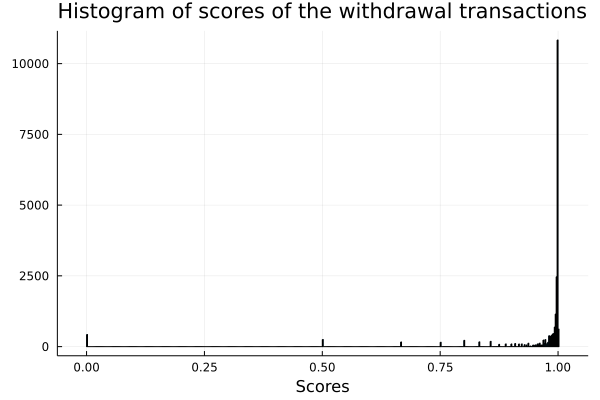

In [32]:
score_values = values(scores) |> collect
histogram(score_values, bins=500, legend=false, title="Histogram of scores of the withdrawal transactions", xlabel="Scores")